# Import

In [1]:
from quspin.basis import spin_basis_1d,photon_basis,boson_basis_1d,tensor_basis # Hilbert space bases
from quspin.operators import hamiltonian # Hamiltonian and observables
from quspin.tools.measurements import obs_vs_time,diag_ensemble # t_dep measurements
from quspin.tools.Floquet import Floquet,Floquet_t_vec # Floquet Hamiltonian
from quspin.basis.photon import coherent_state # HO coherent state
from quspin.tools.block_tools import block_diag_hamiltonian
import numpy as np # generic math functions
import matplotlib.pyplot as plt
import pylab
from numpy import linalg as LA
from scipy.special import comb

# Model parameters

In [2]:
N_osc=5 #number of harmonic oscillators
N_lev=4 # number of energy levels of oscillators
N_tot=N_lev**N_osc # total number of states of all photons
Omega=1.0 # frequency of the oscillator
A=0.2 # spin-photon coupling strength (drive amplitude)
Delta=1.0 # difference between atom energy levels

In [3]:
N_ph_avg=N_lev//2

In [4]:
2*N_tot

2048

# Hamiltonian of a two-state atom in a reservoir of harmonic oscillators 

For the purpose of our study, we take a two-level atom (i.e. a single-site spin chain) and couple it to multiple photon mode (i.e. a quantum harmonic oscillators). The Hamiltonian reads: 
$$ H = \sum_{k=1}^{N_{osc}} \Omega_k a_k^\dagger a_k + \frac{A}{2} \frac{1}{\sqrt{N_{ph~avg}}} \sum_k (a_k^\dagger + a_k) \sigma^x + \Delta \sigma^z$$
where the operator $a^\dagger$ creates a photon in the mode, and the atom is modelled by a two-level system described by the Pauli spin operators $\sigma^{x,y,z}$. 
$N_{osc}$ is the number of harmoniv oscillators in the reservoir, $N_{lev}$ - number of energy levels of a single photon mode.
The photon frequency is $\Omega$, $N_{ph}$ is the average number of photons in a single mode, $A$ - the coupling between the EM field $E=\sum_{k=1}^{N_{osc}}\sqrt{N_{ph~avg}^{-1}}(a_k^\dagger + a_k)$, and the dipole operator $\sigma^x$, and $\Delta$ measures the energy difference between the two atomic states.

To set up the spin-photon Hamiltonian, we first build the site-coupling lists. The ph_energy list does not require the specification of a lattice site index, since the latter is not defined forthe photon sector. The at_energy list, on the other hand, requires the input of the lattice sitefor the $\sigma^z$-operator:  since we consider a single two-level system or, equivalently – a single-site chain, this index is 0. The spin-photon coupling lists absorb and emit also require the site index which refers to the corresponding Pauli matrices: in this model – 0 again due to dimensional constraints.

In [5]:
# define operator site-coupling lists
ph_energy=[[Omega,i] for i in range(N_osc)] # photon energy
at_energy=[[Delta,0]] # atom energy, 0 because the "lattice" is single-site
absorb=[[A/(2.0*np.sqrt(N_ph_avg)),0,i] for i in range(N_osc)] # absorption term
emit=[[A/(2.0*np.sqrt(N_ph_avg)),0,i] for i in range(N_osc)] # emission term

To build the static operator list, we use the $|$ symbol in the operator string to distinguish the spin and photon operators: spin operators always come to the left of the $|$-symbol,  while photon operators - to the right. For convenience, the identity operator $I$ can be omitted, suchthat $I|n$ is the same as $|n$, and $z|I$ is equivalent to $z|$, respectively. The dynamic list is empty since the spin-photon Hamiltonian is time-independent.

In [6]:
# define static and dynamics lists
static_no_interaction=[["|n",ph_energy],["z|",at_energy]]
static_rotating_wave=[["|n",ph_energy],["+|-",absorb],["-|+",emit],["z|",at_energy]]
static_full=[["|n",ph_energy],["x|-",absorb],["x|+",emit],["z|",at_energy]]
dynamic=[]

To build the spin-photon basis, we call the function photon_basis and use spin_basis_1d as the first argument. We need to specify the number of spin lattice sites, and the total numberof harmonic oscillator (a.k.a photon) states.

In [7]:
basis_osc = boson_basis_1d(L=N_osc, sps=N_lev)
#print(basis_osc)

In [8]:
# compute atom-photon basis
#basis_photon_particle=photon_basis(spin_basis_1d, L=1, Nph=L_lev)
basis_osc = boson_basis_1d(L=N_osc,sps=N_lev)
basis_spin = spin_basis_1d(L=1, pauli=-1, S='1/2')
basis = tensor_basis(basis_spin,basis_osc) 
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
	   0.         |1>           1         |3 3 3 3 3>           1023  
	   1.         |1>           1         |3 3 3 3 2>           1022  
	   2.         |1>           1         |3 3 3 3 1>           1021  
	   3.         |1>           1         |3 3 3 3 0>           1020  
	   4.         |1>           1         |3 3 3 2 3>           1019  
	   5.         |1>           1         |3 3 3 2 2>           1018  
	   6.         |1>           1         |3 3 3 2 1>           1017  
	   7.         |1>           1         |3 3 3 2 0>           1016  
	   8.         |1>           1         |3 3 3 1 3>           1015  
	   9.         |1>           1         |3 3 3 1 2>           1014  
	  10.         |1>           1         |3 3 3 1 1>           1013  
	  11.         |1>           1         |3 3 3 1 0>           1012  
	  12.         |1>           1         |3 3 3 0 3>           1011  
	  13.         |1>           1         |3 3 3 0

In [9]:
# import inspect
# inspect.getmembers(tensor_basis)

In [10]:
# compute atom-photon Hamiltonian H
H_no_interaction=hamiltonian(static_no_interaction,dynamic,dtype=np.float64, basis=basis, check_symm=False, check_pcon=False, check_herm=False)
H_full=hamiltonian(static_full,dynamic,dtype=np.float64, basis=basis, check_symm=False, check_pcon=False, check_herm=False)
H_rotating_wave=hamiltonian(static_rotating_wave,dynamic,dtype=np.float64, basis=basis, check_symm=False, check_pcon=False, check_herm=False)

In [11]:
#print('Number of states of Hamiltonian:', H_rotating_wave.Ns)

# Spectrum 

In [12]:
# calculate entire spectrum only
eigenvalues_H_no_interaction=H_no_interaction.eigvalsh()
eigenvalues_H_full=H_full.eigvalsh()
eigenvalues_H_rotating_wave=H_rotating_wave.eigvalsh()

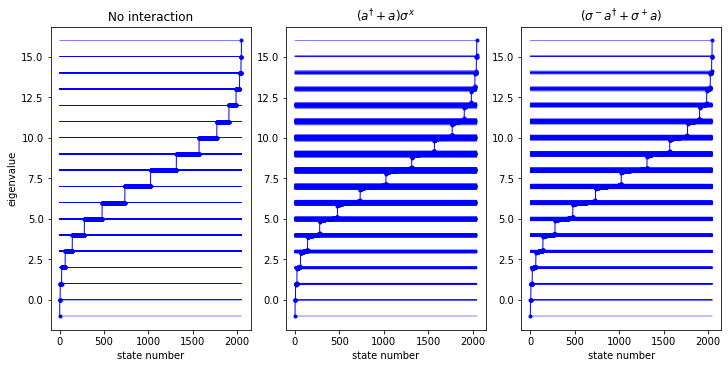

In [13]:
##### plot spectra
fig, ax = plt.subplots(nrows=1, ncols=3, constrained_layout=True,figsize=(10,5))
x = np.arange(H_no_interaction.Ns)
ax[0].plot(x,eigenvalues_H_no_interaction, '.-', color='b', lw=1.)
ax[1].plot(x,eigenvalues_H_full, '.-', color='b', lw=1.)
ax[2].plot(x,eigenvalues_H_rotating_wave, '.-', color='b', lw=1.)
for level in x :
    ax[0].plot(x,np.full(H_no_interaction.Ns,eigenvalues_H_no_interaction[level]), '-', color='b', lw=0.5)
    ax[1].plot(x,np.full(H_full.Ns,eigenvalues_H_full[level]), '-', color='b', lw=0.5)
    ax[2].plot(x,np.full(H_rotating_wave.Ns,eigenvalues_H_rotating_wave[level]), '-', color='b', lw=0.5)
ax[0].set(title='No interaction', xlabel='state number', ylabel='eigenvalue'); ax[0].grid(False)
ax[1].set(title='$(a^\dag+a)\sigma^x$', xlabel='state number'); ax[1].grid(False)
ax[2].set(title='$(\sigma^- a^\dag+\sigma^+ a)$', xlabel='state number'); ax[1].grid(False)
plt.show()

# Blocks

In [14]:
# size of of the particle-conserved basis of bosons
def boson_block_size(N_sites, N_levels, N_particles):
    Ns=0
    for r in range(N_particles//N_levels+1):
        r_2 = N_particles - r*N_levels
        if r % 2 == 0:
            Ns +=  comb(N_sites,r,exact=True) * comb(N_sites + r_2 - 1,r_2,exact=True)
        else:
            Ns += -comb(N_sites,r,exact=True) * comb(N_sites + r_2 - 1,r_2,exact=True)
    return Ns

In [15]:
boson_block_size(N_osc, N_lev, 1)

5

In [16]:
def hamitonian_eigenvalues_one_block(N_block, static_list, dynamic_list) :
    basis_osc_block = boson_basis_1d(L=N_osc, Nb={N_block-1,N_block,N_block+1}, sps=N_lev)    # boson basis with chosen number of particles
    basis_osc_block_size = len(basis_osc_block.states)
    basis_block = tensor_basis(basis_spin,basis_osc_block)                 # mixed atom-boson basis

    basis_osc_block_n = boson_basis_1d(L=N_osc, Nb={N_block}, sps=N_lev)     # part of boson basis
    selected_indices_n_up_spin = basis_osc_block_size - np.searchsorted(np.flip(basis_osc_block.states), basis_osc_block_n.states) - 1 
    size_next_level = len(selected_indices_n_up_spin)
    selected_indices_n_down_spin = 2*basis_osc_block_size - np.searchsorted(np.flip(basis_osc_block.states), basis_osc_block_n.states) - 1   
    size_prev_level = len(selected_indices_n_down_spin)
    
    basis_osc_block_n_minus_1 = boson_basis_1d(L=N_osc, Nb={N_block-1}, sps=N_lev)     # part of boson basis
    selected_indices_n_minus_1 = basis_osc_block_size - np.searchsorted(np.flip(basis_osc_block.states), basis_osc_block_n_minus_1.states) - 1  # only spin up
    
    basis_osc_block_n_plus_1 = boson_basis_1d(L=N_osc, Nb={N_block+1}, sps=N_lev)
    selected_indices_n_plus_1 = 2*basis_osc_block_size - np.searchsorted(np.flip(basis_osc_block.states), basis_osc_block_n_plus_1.states) - 1
    size_current_level = len(selected_indices_n_plus_1) + len(selected_indices_n_minus_1)
    
    all_selected_indices = np.concatenate((selected_indices_n_up_spin,selected_indices_n_down_spin,selected_indices_n_minus_1,selected_indices_n_plus_1))   # only spin down
    
    hamiltonian_full = hamiltonian(static_list,dynamic_list,dtype=np.float64, basis=basis_block, check_symm=False, check_pcon=False, check_herm=False).toarray()
    #print(hamiltonian_full)
    ixgrid = np.ix_(all_selected_indices, all_selected_indices)
    hamiltonian_rectified = hamiltonian_full[ixgrid]
    print('Size of the reduced matrix: ', hamiltonian_rectified.shape)
    block_eigen_vals = LA.eigvalsh(hamiltonian_rectified)
    return block_eigen_vals[size_prev_level:size_prev_level+size_current_level:]

In [17]:
hamitonian_eigenvalues_one_block(0, static_rotating_wave, dynamic)

Size of the reduced matrix:  (7, 7)


array([-2.44044241e-02, -4.89861225e-17,  0.00000000e+00,  0.00000000e+00,
        2.12305469e-17])

In [18]:
block_eigen_vals = hamitonian_eigenvalues_one_block(0, static_rotating_wave, dynamic)

Size of the reduced matrix:  (7, 7)


In [19]:
blocks_hamiltonian_eigenvalues = [np.array([-1])]
for N_block in range(0,(N_lev-1)*N_osc) : 
    blocks_hamiltonian_eigenvalues.append(hamitonian_eigenvalues_one_block(N_block, static_rotating_wave, dynamic))

Size of the reduced matrix:  (7, 7)
Size of the reduced matrix:  (26, 26)
Size of the reduced matrix:  (70, 70)
Size of the reduced matrix:  (150, 150)
Size of the reduced matrix:  (266, 266)
Size of the reduced matrix:  (402, 402)
Size of the reduced matrix:  (526, 526)
Size of the reduced matrix:  (600, 600)
Size of the reduced matrix:  (600, 600)
Size of the reduced matrix:  (526, 526)
Size of the reduced matrix:  (402, 402)
Size of the reduced matrix:  (266, 266)
Size of the reduced matrix:  (150, 150)
Size of the reduced matrix:  (70, 70)
Size of the reduced matrix:  (26, 26)


# Check

In [21]:
basis_osc_block = boson_basis_1d(L=N_osc, Nb={3,4,5}, sps=N_lev)    # boson basis with chosen number of particles
basis_block = tensor_basis(basis_spin,basis_osc_block)   

In [22]:
H_block_no_interaction=hamiltonian(static_rotating_wave,dynamic,dtype=np.float64, basis=basis_block, check_symm=False, check_pcon=False, check_herm=False)

In [23]:
# with np.printoptions(threshold=np.inf):
#     print(H_block_no_interaction.toarray())

In [24]:
eigenvalues_H_block_no_interaction=H_block_no_interaction.eigvalsh()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
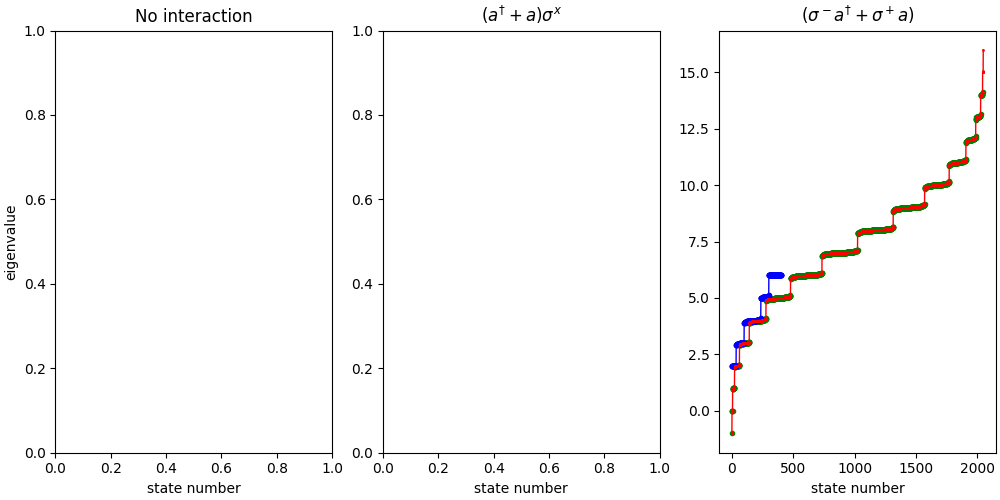

In [25]:
%matplotlib widget
##### plot spectra
fig, ax = plt.subplots(nrows=1, ncols=3, constrained_layout=True,figsize=(10,5))
nb_of_states = H_block_no_interaction.Ns
state_counter = 0
for i, block in enumerate(blocks_hamiltonian_eigenvalues) :
    x = np.arange(state_counter, state_counter+len(block))
    #print(x)
    state_counter = state_counter + len(block)
    ax[2].plot(x, block, '.-', color='g', lw=1.)
ax[2].plot(np.arange(nb_of_states),eigenvalues_H_block_no_interaction, '.-', color='b', lw=1.)
#ax[0].plot(np.arange(H_no_interaction.Ns),eigenvalues_H_no_interaction, '-', color='r', lw=1.)
ax[2].plot(eigenvalues_H_rotating_wave, '.-', color='r', lw=1., ms=2.0)
#ax[2].plot(x,eigenvalues_H_rotating_wave, '.-', color='b', lw=1.)
#for level in np.arange(nb_of_states) :
    #ax[0].plot(np.arange(nb_of_states),np.full(nb_of_states,eigenvalues_H_block_no_interaction[level]), '-', color='b', lw=0.5)
    #ax[1].plot(x,np.full(H_full.Ns,eigenvalues_H_full[level]), '-', color='b', lw=0.5)
    #ax[2].plot(x,np.full(H_rotating_wave.Ns,eigenvalues_H_rotating_wave[level]), '-', color='b', lw=0.5)
ax[0].set(title='No interaction', xlabel='state number', ylabel='eigenvalue'); ax[0].grid(False)
ax[1].set(title='$(a^\dag+a)\sigma^x$', xlabel='state number'); ax[1].grid(False)
ax[2].set(title='$(\sigma^- a^\dag+\sigma^+ a)$', xlabel='state number'); ax[1].grid(False)
plt.show()